# PySpark tutorial for beginners

This notebook is a part of my learning journey which I've been documenting from Udacity's Data Scientist Nanodegree program, which helped me a lot to learn and excel advanced data science stuff such as PySpark. Thank you so much Udacity for providing such quality content. 

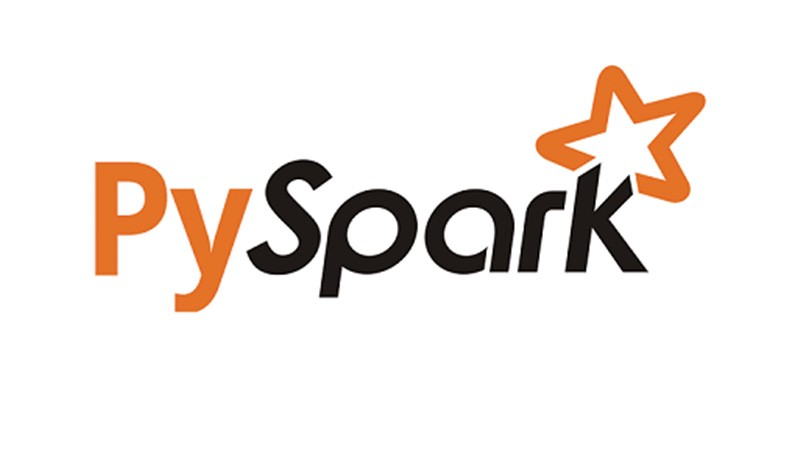

Spark is a  big data framework which contains libraries for data analysis, machine learning, graph analysis, and streaming live data. Spark is generally faster than Hadoop. This is because Hadoop writes intermediate results to disk whereas Spark tries to keep intermediate results in memory whenever possible.

The Hadoop ecosystem includes a distributed file storage system called HDFS (Hadoop Distributed File System). Spark, on the other hand, does not include a file storage system. You can use Spark on top of HDFS but you do not have to. Spark can read in data from other sources as well such as Amazon S3.

Spark doesn't implement MapReduce, you can write Spark programs that behave in a similar way to the map-reduce pattern.

**Limitations of spark:**

- Spark Streaming’s latency is at least 500 milliseconds since it operates on micro-batches of records, instead of processing one record at a time. Native streaming tools such as Storm, Apex, or Flink can push down this latency value and might be more suitable for low-latency applications. Flink and Apex can be used for batch computation as well, so if you're already using them for stream processing, there's no need to add Spark to your stack of technologies.

- Another limitation of Spark is its selection of machine learning algorithms. Currently, Spark only supports algorithms that scale linearly with the input data size. In general, deep learning is not available either, though there are many projects integrate Spark with Tensorflow and other deep learning tools.

Source:- Spark and Pyspark documentation

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Maps 
Maps take data as input and then transform that data with whatever function you put in the map. 
They are like directions for the data telling how each input should get to the output.

First, we need to create a SparkContext object. With the SparkContext, you can input a dataset and parallelize the data across a cluster.

In [ ]:
!pip install pyspark

In [ ]:
import pyspark
sc = pyspark.SparkContext(appName="intro_to_spark")

log_of_songs = [
        "Despacito",
        "Nice for what",
        "No tears left to cry",
        "Despacito",
        "Havana",
        "In my feelings",
        "Nice for what",
        "despacito",
        "All the stars"
]

# parallelize the log_of_songs to use with Spark
distributed_song_log = sc.parallelize(log_of_songs)

In [ ]:
def convert_song_to_lowercase(song):
    return song.lower()

map step will go through each song in the list and apply the convert_song_to_lowercase() function.

In [ ]:
distributed_song_log.map(convert_song_to_lowercase)

You'll notice that this code cell ran quite quickly. This is because of lazy evaluation. Spark does not actually execute the map step unless it needs to.

"RDD" in the output refers to resilient distributed dataset. RDDs are exactly what they say they are: fault-tolerant datasets distributed across a cluster. This is how Spark stores data.

To get Spark to actually run the map step, you need to use an "action". One available action is the collect method. The collect() method takes the results from all of the clusters and "collects" them into a single list on the master node.

In [ ]:
distributed_song_log.map(convert_song_to_lowercase).collect()

Note as well that Spark is not changing the original data set: Spark is merely making a copy. You can see this by running collect() on the original dataset.

In [ ]:
distributed_song_log.collect()

# Reading and Writing Data with Spark


In [ ]:
from pyspark import SparkConf
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession \
    .builder \
    .appName("intro_to_spark") \
    .getOrCreate()

In [ ]:
spark.sparkContext.getConf().getAll()

In [ ]:
spark

Now, let's create our first dataframe from a small sample data set which is a log file data set that describes user interactions with a music streaming service. The records describe events such as logging in to the site, visiting a page, listening to the next song, seeing an ad.

In [ ]:
path = "../input/sparkify-log-small"
user_log = spark.read.json(path)

In [ ]:
user_log.printSchema()

In [ ]:
user_log.describe()

In [ ]:
user_log.show(n=1)

In [ ]:
user_log.take(5)

Now let's save this as a csv file

In [ ]:
out_path = ".//sparkify_log_small.csv"
user_log.write.save(out_path, format="csv", header=True)

In [ ]:
user_log_2 = spark.read.csv(out_path, header=True)

In [ ]:
user_log_2.printSchema()

In [ ]:
user_log_2.take(2)

In [ ]:
user_log_2.select("userID").show()

# Data Exploration


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
path = "../input/sparkify-log-small/sparkify_log_small.json"
user_log = spark.read.json(path)

In [ ]:
user_log.take(5)

In [ ]:
user_log.printSchema()

In [ ]:
user_log.describe().show()

In [ ]:
user_log.describe("artist").show()

In [ ]:
user_log.describe("sessionId").show()

In [ ]:
user_log.count()

In [ ]:
user_log.select("page").dropDuplicates().sort("page").show()

In [ ]:
user_log.select(["userId", "firstname", "page", "song"]).where(user_log.userId == "1046").collect()

# Calculating Statistics by Hour

In [ ]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [ ]:
user_log = user_log.withColumn("hour", get_hour(user_log.ts))

In [ ]:
user_log.head()

In [ ]:
songs_in_hour = user_log.filter(user_log.page == "NextSong").groupby(user_log.hour).count().orderBy(user_log.hour.cast("float"))
songs_in_hour.show()

In [ ]:
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

# Drop Rows with Missing Values

In [ ]:
user_log_valid = user_log.dropna(how = "any", subset = ["userId", "sessionId"])

In [ ]:
user_log_valid.count()

In [ ]:
user_log.select("userId").dropDuplicates().sort("userId").show()

In [ ]:
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")

In [ ]:
user_log_valid.count()

# Users Downgrade Their Accounts

Let's find when users downgrade their accounts and then flag those log entries.

In [ ]:
user_log_valid.filter("page = 'Submit Downgrade'").show()

In [ ]:
user_log.select(["userId", "firstname", "page", "level", "song"]).where(user_log.userId == "1138").collect()

In [ ]:
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [ ]:
user_log_valid = user_log_valid.withColumn("downgraded", flag_downgrade_event("page"))

In [ ]:
user_log_valid.head()

In [ ]:
from pyspark.sql import Window

In [ ]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [ ]:
user_log_valid = user_log_valid.withColumn("phase", Fsum("downgraded").over(windowval))

In [ ]:
user_log_valid.select(["userId", "firstname", "ts", "page", "level", "phase"]).where(user_log.userId == "1138").sort("ts").collect()